In [ ]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load event file
filename = "/Users/ogilbert/Desktop/PhD/Courses/ASTRO532/cluster_assignment/13468/primary/acisf13468N003_evt2.fits.gz"
with fits.open(filename) as hdul:
    events = hdul["EVENTS"].data

x = events["x"]
y = events["y"]

# Histogram events to make image
nbins = 2048  # 4096 pixels ~ full field; 8192 gives finer sampling
xrange = [x.min(), x.max()]
yrange = [y.min(), y.max()]
img, xedges, yedges = np.histogram2d(x, y, bins=nbins, range=[xrange, yrange])

cutout = img.T[700:1200,1150:1650]









def net_flux(image, target_pos, noise_pos, radius=40, noise_radius=50, if_plot=False, verbose=False):
    '''
    Calculates the approximate flux of a source by substracting the noise of its nearby background

    Parameters:
    image: image data with the source (2D array)
    target_pos: list of position of the source (e.g. [100, 200])
    radius: approximate radius of the source object
    if_plot: boolean, if True, plot only the flux within the radius
    
    Returns the estimated flux of the source
    '''
    x0, y0 = target_pos[0], target_pos[1]
    x1, y1 = noise_pos[0], noise_pos[1]
    pixels_inside, pixels_noise = 0, 0
    within_flux = 0#np.zeros(image[y0-2*radius:y0+2*radius, x0-2*radius:x0+2*radius].shape)
    noise_flux = 0#np.zeros(image[y1-2*noise_radius:y1+2*noise_radius, x1-2*noise_radius:x1+2*noise_radius].shape)
    for y, line in enumerate(image[y0-2*radius:y0+2*radius, x0-2*radius:x0+2*radius]):
        for x, val in enumerate(line):
            if np.sqrt((x-2*radius-1)**2+(y-2*radius)**2)<=radius:
                within_flux+=val#[y, x] = val
                pixels_inside += 1
    for y, line in enumerate(image[y1-2*noise_radius:y1+2*noise_radius, x1-2*noise_radius:x1+2*noise_radius]):
        for x, val in enumerate(line):
            if np.sqrt((x-2*noise_radius-1)**2+(y-2*noise_radius)**2)<=noise_radius:
                noise_flux+=val#[y, x] = val
                pixels_noise += 1
    
    

    flux_within = within_flux#np.sum(within_flux)
    flux_noise = noise_flux#np.sum(noise_flux)
    flux_source = flux_within - (flux_noise/pixels_noise)*pixels_inside
    if verbose:
        print(f'-----------------------------')
        print(f'raw flux source: {flux_within}')
        print(f'flux noise: {flux_noise}')
        print(f'net flux source: {flux_source}')
        print(f'-----------------------------')
    if if_plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.suptitle(f'Net flux of source: {flux_source}')

        circle1 = plt.Circle((2*radius+1, 2*radius), radius, color='white', fill=False)
        circle2 = plt.Circle((2*noise_radius+1, 2*noise_radius), noise_radius, color='white', fill=False)
        circle3 = plt.Circle(tuple(target_pos), radius, color='white', fill=False)
        circle4 = plt.Circle(tuple(noise_pos), noise_radius, color='white', fill=False)
        ax1.set_title(label=f'Raw flux of source: {flux_within}\nNumber of pixels: {pixels_inside}')
        ax2.set_title(label=f'Flux noise: {flux_noise}\nNumber of pixels: {pixels_noise}\nNoise density: {flux_noise/pixels_noise}')
        ax1.imshow(image[y0-2*radius:y0+2*radius, x0-2*radius:x0+2*radius], origin='lower')
        ax2.imshow(image[y1-2*noise_radius:y1+2*noise_radius, x1-2*noise_radius:x1+2*noise_radius], origin='lower')
        ax3.imshow(image, origin='lower')
        ax1.add_patch(circle1)
        ax2.add_patch(circle2)
        ax3.add_patch(circle3)
        ax3.add_patch(circle4)
        plt.show()
    return flux_source
fluxes = []
radii = np.linspace(5,250,245)
for r in tqdm(radii):
    fluxes.append(net_flux(img.T, target_pos=(1400,950), noise_pos=(800,400), radius=int(r), noise_radius=200, if_plot=False))
data = np.array([radii, fluxes])
np.savetxt("flux_data.txt", data.T)



  4%|▎         | 7/195 [00:03<01:41,  1.86it/s]


KeyboardInterrupt: 

2559.340234195999


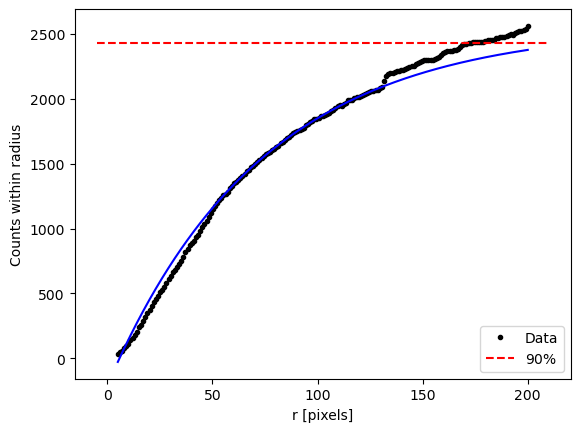

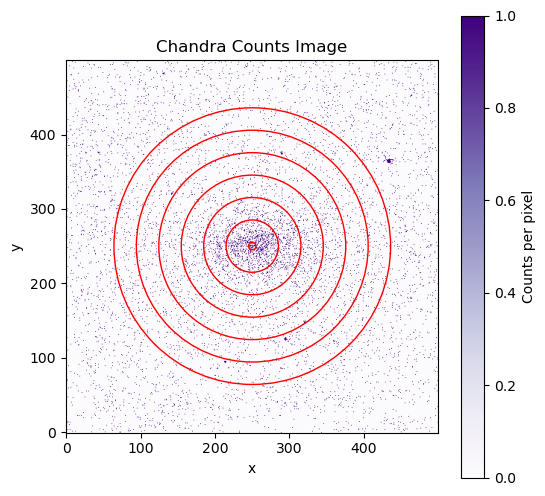

In [116]:
from scipy.optimize import curve_fit

def func(r,a,b,c):
    return a*(1-np.exp(-b*r))+c
data = np.loadtxt("flux_data.txt")
radii = data[:,0]
fluxes = data[:,1]
mask = ((radii<125) & (radii > 50))
res = curve_fit(func, radii[mask], fluxes[mask], p0=(2528, 0.012, 35))[0]

# At $r\to \infty$, this will converge to a+c
# We can consider the radius at which the counts are 95% of the total counts
print(res[0]+res[2])
counts_outer_radius = (res[0]+res[2])*0.95

plt.plot(radii, fluxes, color="black", marker=".", ls="None", label="Data")
plt.plot(radii, func(radii, *res), ls="-", marker="None", color="blue")
plt.hlines(counts_outer_radius, *plt.xlim(), ls="--", color="red", label=r"$90\%$")
plt.legend(loc="lower right")
plt.xlabel("r [pixels]")
plt.ylabel("Counts within radius")
plt.show()
plt.figure(figsize=(6,6))
plt.imshow(cutout, origin="lower", cmap="Purples", vmax=1)
ax1 = plt.subplot(111)
for r in radii[::30]:
    circle1 = plt.Circle((250,250), r, color='red', fill=False)
    ax1.add_patch(circle1)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Chandra Counts Image")
plt.colorbar(label="Counts per pixel")
plt.show()

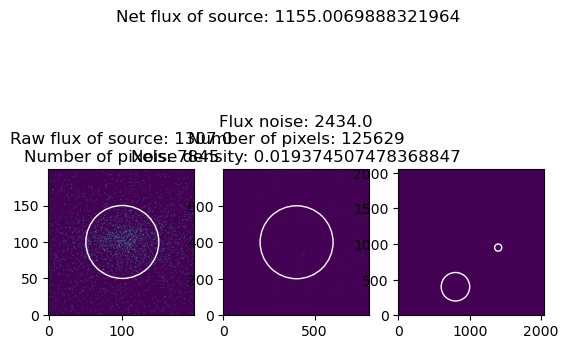

np.float64(1155.0069888321964)

In [111]:
net_flux(img.T, target_pos=(1400,950), noise_pos=(800,400), radius=int(50), noise_radius=200, if_plot=True)